[![colab-logo](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/japan-medical-ai/medical-ai-course-materials/blob/master/notebooks/Blood_Cell_Detection.ipynb)

# 実践編: 血液の顕微鏡画像からの細胞検出

ここでは血液細胞の検出タスクに取り組みます．人の血液の顕微鏡画像が与えられたときに，

- 赤血球（Red Blood Cell; RBC）
- 白血球（White Blood Cell; WBC）
- 血小板（Platelet）

の3種の細胞について，それぞれ**何がどの位置にあるか**を個別に認識する方法を考えます．
これが可能になると，与えられた画像内に**それらの細胞が何個ずつあるか，また，どういう位置にあるか**，ということが分かります。

このようなタスクは一般に**物体検出（object detection）**と呼ばれます．画像を入力として，対象の物体（ここでは例えば、上の3種の細胞）ごとに，個別に

1. 物体を包含する最小面積の矩形（Bounding boxと呼ばれる）
2. 「内側にある物体が何か」＝クラスラベル

を推定することを目的とします．
ただし，**画像中にいくつの物体が含まれるかは事前に分からない**ため，任意個（または十分な数）の物体の**Bounding boxとクラスラベルの予測値の組**を出力できるような手法である必要があります．

Bounding box（以下bbox）は，`[矩形の左上のy座標, 矩形の左上のx座標, 矩形の右下のy座標, 矩形の右下のx座標]`のような形式で定義されることが多く，クラスは物体の種類ごとに割り振られたID（以下クラスラベル）で表されることが多いようです．例えば，RBCは0，WBCは1，Plateletは2といったように，対象とする物体に1体1対応した非負整数が割り当てられるのが一般的です．

以下に，今回この資料で用いる**細胞画像のデータセット**から１例を取り出し，その画像の上に正解として与えられているbboxと，それに対応するクラスの名前を可視化したものを示します．

赤い長方形がbboxと呼ばれるものです．対象となる血液細胞を一つ一つ，別々の長方形が囲っていることがわかります．この長方形の上辺に重なるように白いラベルが表示されています．それがその矩形の内部にある物体の種類（クラス）を表しています．

![detection_sample.png](https://github.com/mitmul/medical-ai-course-materials/raw/master/notebooks/images/detection_samples.png)

（上図：血液の顕微鏡画像からRBC, WBC, Plateletを検出している例）



## 環境構築

まず環境構築のためColab上で以下のセルを実行してChainer, CuPy, ChainerCV, matplotlibといったPythonパッケージのインストールを済ませましょう．
これらのステップは前回までと同様です．

In [0]:
!curl https://colab.chainer.org/install | sh -  # ChainerとCuPyのインストール
!pip install chainercv matplotlib               # ChainerCVとmatplotlibのインストール

それでは，先程のセルの実行によって環境のセットアップが成功したことを以下のセルを実行して確認しましょう．

In [0]:
import chainer

chainer.print_runtime_info()

Platform: Linux-4.14.65+-x86_64-with-Ubuntu-18.04-bionic
Chainer: 5.0.0
NumPy: 1.14.6
CuPy:
  CuPy Version          : 5.0.0
  CUDA Root             : /usr/local/cuda
  CUDA Build Version    : 9020
  CUDA Driver Version   : 9020
  CUDA Runtime Version  : 9020
  cuDNN Build Version   : 7201
  cuDNN Version         : 7201
  NCCL Build Version    : 2213
iDeep: Not Available


## 物体検出（Object detection）

物体検出（object detection）は，Computer Visionの応用分野で現在も活発に研究が行われているタスクの一つで，自動運転やロボティクスなど幅広い領域で重要な役割を果たす技術です．Semantic Segmentationと違い，物体の形（輪郭）までは認識しませんが，**物の種類と位置を，物体ごとに個別に出力**します．

「物の種類」をクラスと呼ぶとき，そのクラスに属する個別の物体をインスタンスと呼ぶことができます．すると，犬が2匹写っている写真があるとき，それは「犬」というクラスに属しているインスタンスが2個ある，という状態だと言えます．つまり，この前の章で学習したSemantic Segmentationというタスクでは**インスタンスごとに領域が区別されて出力されるわけではなかった**一方で，**物体検出の出力はインスタンスごとになる（インスタンスごとに別々のbboxが出力される）**という違いがあります．こういった出力の形を "instance-wise" という言葉で表現する場合もあります．

ニューラルネットワークを用いた物体検出手法は，[R-CNN](https://arxiv.org/abs/1311.2524)という2014年に発表された手法を皮切りに，様々な改善手法が提案されてきました．まず一つの流れとして，[R-CNN](https://arxiv.org/abs/1311.2524), [Fast R-CNN](https://arxiv.org/abs/1504.08083), そして[Faster R-CNN](https://arxiv.org/abs/1506.01497)という物体検出手法は，はじめに物体の候補を推定し，次に各候補毎に物体のクラスや位置を詳細に推定します．これは**two stageタイプ**と呼ばれています．

それに対して，同じくCNNをベースとはしているものの，**single stageタイプ**と呼ばれている手法があります．[SSD](https://arxiv.org/abs/1512.02325)や[YOLO](https://arxiv.org/abs/1506.02640)，[YOLOv2](https://arxiv.org/abs/1612.08242)，[YOLOv3](https://arxiv.org/abs/1804.02767)などがsingle stageタイプとしてよく知られています．これらは物体の候補を生成せず．直接各物体のクラスと位置を推定します．一般的にsingle stageタイプの方がtwo stageタイプよりも処理速度は高速である一方，精度が低いと言われています．ただし，最近はこれらの手法の境界は曖昧になり、性能差もほとんどなくなってきています．

ここでは，single stageタイプの物体検出手法の一つ，SSDを使って，細胞画像から三種類の細胞の位置と種類を抽出するタスクに挑戦します．

## データセットの準備

### データセットダウンロード

まずは[BCCD Dataset](https://github.com/Shenggan/BCCD_Dataset)という，血液の顕微鏡画像のデータセットを用意します．このデータセットには，364枚の画像と，その画像それぞれに対応したファイル名のXMLファイルが含まれています．XMLファイルには，対応する画像中に登場したRBC, WBC, Plateletの3つのいずれかの細胞を囲むBounding boxの座標情報が格納されています．一つの画像中に複数の細胞が含まれている場合があるため，XMLファイルには複数の細胞についての記載が含まれる場合があります．

BCCD Datasetは広く物体検出の研究に用いられているようなベンチマークデータセットに比べると非常に小規模であり，Github上で配布されています．以下のセルを実行してまずはデータセットをダウンロードしてみましょう．

In [0]:
!if [ ! -d BCCD_Dataset ]; then git clone https://github.com/Shenggan/BCCD_Dataset.git; fi

ダウンロードが完了したら，`BCCD_Dataset`ディレクトリ以下のファイル構成を見てみましょう．このデータセットは，以下のようなファイル構成で配布されています．

```
 BCCD
 |-- Annotations
 |   |
 |   `-- BloodImage_00XYZ.xml (364 items)
 |
 |-- ImageSets
 |   |
 |   `-- Main
 |       |
 |       |-- test.txt
 |       |-- train.txt
 |       `-- val.txt
 |
 `-- JPEGImages
   |
    `-- BloodImage_00XYZ.jpg (364 items)
 ```

この構成は，長年物体検出の標準的ベンチマークデータセットとして用いられてきた**Pascal VOCデータセット**の形式に沿ったものとなっています．そのため，ChainerCVが用意しているPascal VOCデータセットを容易に扱えるようにするクラスをほとんどそのまま流用することが可能です．

実際には他にもディレクトリがありますが，今回用いるのは上記のファイルツリーに含まれているものだけとなります．それぞれのディレクトリに含まれているものを説明します．

- **Annotationsディレクトリ：**Pascal VOCデータセットと同様の形式で細胞画像それぞれに対して**どの位置に何があるか**という正解情報が格納されています．正解情報はXMLファイルとして格納されており，画像ファイルとの対応がわかりやすいように拡張子を除いて同一のファイル名で保存されています．
- **ImageSetsディレクトリ：**学習用データセット（train）・検証用データセット（val）・テスト用データセット（test）のそれぞれに用いる画像のリストが記されたテキストファイルが入っています．これらのリストに従って，データセットを三分割し，それぞれ`train.txt`にリストアップされた画像を学習に，`val.txt`にリストアップされた画像を検証（学習中に汎化性能を大雑把に調べるために使うデータセットスプリット）に，`test.txt`にリストアップされた画像を学習終了後の最終的な性能評価に用います．
- **JPEGImagesディレクトリ：**このデータセットに含まれるすべての画像データが入っています．

### データセットオブジェクト作成

ChainerCVにはPascal VOCデータセットを簡単に読み込むための便利なクラスが用意されています．これを継承し，`_get_annotations`メソッドをオーバーライドして，今回使用するデータセットを読み込み可能にします．変更が必要な行は１行だけです．[こちら](https://github.com/chainer/chainercv/blob/v0.10.0/chainercv/datasets/voc/voc_bbox_dataset.py#L90-L115)から該当するコード（`_get_annotations`メソッドの部分）をコピーしてきて，以下の変更を行い，`VOCBboxDataset`を継承する`BCCDDataset`クラスのメソッドとして追加してみましょう．
（以下はdiff形式とよばれ-でははじまる行を削除し，+で始まる行を追加するという意味です）

```
- label.append(voc_utils.voc_bbox_label_names.index(name))
+ label.append(bccd_labels.index(name))
```

In [0]:
import os
import xml.etree.ElementTree as ET

import numpy as np

from chainercv.datasets import VOCBboxDataset


bccd_labels = ('rbc', 'wbc', 'platelets')


class BCCDDataset(VOCBboxDataset):

    def _get_annotations(self, i):
        id_ = self.ids[i]
        
        # Pascal VOC形式のアノテーションデータは、XML形式で配布されています
        anno = ET.parse(
            os.path.join(self.data_dir, 'Annotations', id_ + '.xml'))

        # XMLをパースして，bboxの座標・大きさ，bboxごとのクラスラベルなどの
        # 情報を取り出し，リストに追加していきます
        bbox = []
        label = []
        difficult = []
        for obj in anno.findall('object'):
            bndbox_anno = obj.find('bndbox')
            
            # bboxの座標値が0-originになるように1を引いています
            # subtract 1 to make pixel indexes 0-based
            bbox.append([
                int(bndbox_anno.find(tag).text) - 1
                for tag in ('ymin', 'xmin', 'ymax', 'xmax')])
            name = obj.find('name').text.lower().strip()
            label.append(bccd_labels.index(name))
        bbox = np.stack(bbox).astype(np.float32)
        label = np.stack(label).astype(np.int32)
        
        # オリジナルのPascal VOCには，difficultという
        # 属性が画像ごとに真偽値で与えられていますが，今回は用いません
        # （今回のデータセットでは全画像がdifficult = 0に設定されているため）
        # When `use_difficult==False`, all elements in `difficult` are False.
        difficult = np.array(difficult, dtype=np.bool)
        return bbox, label, difficult

さて，これで学習や検証，テストなどにデータセットを用いるためのデータ読み込みとパース等を行うクラスを準備することができました．さっそくこのクラスを用いて学習・検証・テスト用のデータセットオブジェクトを作成してみましょう．

In [0]:
train_dataset = BCCDDataset('BCCD_Dataset/BCCD', 'train')
valid_dataset = BCCDDataset('BCCD_Dataset/BCCD', 'val')
test_dataset = BCCDDataset('BCCD_Dataset/BCCD', 'test')

/usr/local/lib/python3.6/dist-packages/chainercv/datasets/voc/voc_bbox_dataset.py:63: UserWarning: please pick split from 'train', 'trainval', 'val'for 2012 dataset. For 2007 dataset, you can pick 'test' in addition to the above mentioned splits.
  'please pick split from \'train\', \'trainval\', \'val\''


ここで警告が表示されるかもしれませんが，特に気にしなくても大丈夫です．本来Pascal VOCデータセットだけに特化して作られたクラスをBCCD Datasetに使っているため出ているものです．

さて，3つのデータセットオブジェクトを作成することができました．それぞれの大きさ（いくつのデータが含まれているか）を確認してみましょう．

In [0]:
print('Number of images in "train" dataset:', len(train_dataset))
print('Number of images in "valid" dataset:', len(valid_dataset))
print('Number of images in "test" dataset:', len(test_dataset))

Number of images in "train" dataset: 205
Number of images in "valid" dataset: 87
Number of images in "test" dataset: 72


では，`train_dataset`の１つ目のデータにアクセスしてみましょう．

In [0]:
first_datum = train_dataset[0]

さて，`train_dataset`は`VOCBboxDataset`を継承した`BCCDDataset`クラスのオブジェクトでした．そのため，上でオーバーライドした`_get_annotations`メソッド以外は，`VOCBboxDataset`クラスが提供する機能を継承しているはずです．どのような機能が提供されているのか，`VOCBboxDataset`クラスのドキュメントを見て確認してみましょう：[VOCBboxDataset](https://chainercv.readthedocs.io/en/stable/reference/datasets.html?highlight=VOCBboxDataset#vocbboxdataset)



以下のような表が記載されています．このデータセットは，それぞれの要素に以下のようなものを持つリストのようになっています．

| name	| shape |	dtype | 	format |
|:--|:--|:--|:--|
| img | (3,H,W) | float32 | RGB, [0,255] |
| bbox | (R,4) | float32 | (ymin,xmin,ymax,xmax) |
| label | (R,) | int32 | [0,#fg_class−1] |
| difficult (optional)* | (R,) | bool | – |

* #fg_classはforeground（前景）のクラス数
* difficult is available only if `return_difficult = True`

ただし，今回データセットオブジェクトを作成する際に`return_difficult`オプションを明示的に`True`と指定していないので，デフォルト値の`False`が使われていません。そのため上の表の最後の行にある`difficult`という要素は返ってきません．

今回作成した3つのデータセットオブジェクトはすべて，**それぞれの要素が`(画像データ, 正解のbboxリスト, 各bboxごとのクラス)`という３つの配列となっている

In [0]:
len(first_datum)

3

確かに，要素数は3でした．では，画像データを取り出して，そのshapeとdtypeを見てみます．

In [0]:
print(first_datum[0].shape, first_datum[0].dtype)

(3, 480, 640) float32


確かに，`(3=チャンネル数, H=高さ, W=幅)`という形になっており，またデータ型は`float32`になっています．上の表にあったとおりでした．ではbboxはどのような形式になっているのでしょうか．中身と，そのshapeを表示して見てみます．

In [0]:
print(first_datum[1])
print(first_datum[1].shape)

[[314.  67. 479. 285.]
 [360. 345. 453. 445.]
 [178.  52. 298. 145.]
 [399. 448. 479. 535.]
 [131. 460. 211. 547.]
 [294. 453. 374. 540.]
 [282. 416. 382. 507.]
 [341. 277. 450. 368.]
 [ 61. 544. 158. 635.]
 [ 90. 484. 187. 575.]
 [170. 375. 252. 437.]
 [176. 328. 270. 394.]
 [ 58. 290. 167. 406.]
 [  0. 298.  67. 403.]
 [ 25. 345. 137. 448.]
 [  0. 133.  94. 240.]
 [ 37.   0. 163.  97.]
 [159. 164. 263. 256.]
 [208. 463. 318. 565.]]
(19, 4)


19個のbboxの情報が並んでおり，ひとつひとつは`(y_min, x_min, y_max, x_max)`という4つの数字で表されています．この4つの数字はbboxの左上と右下の画像座標値（画像平面上の位置）を表しています．

画像内に登場している物体のそれぞれについて，この4つの数字を出力するというのが物体検出の一つの目的となります．ただし，それだけでなく，それぞれのbboxがどのクラスに属しているか（そのbboxの内部にある物体の種類）も出力する必要があります．これについての正解情報が，最後の要素に入っています．これを表示してみます．

In [0]:
print(first_datum[2])
print(first_datum[2].shape)

[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
(19,)


19個の数字が入っていました．これはそれぞれ，上で表示してみたbbox（`first_datum[1]`）に順番に対応しており，それぞれのbboxがどのクラスに属する物体か（0: RBC, 1: WBC, 2: Platelet）を表しています．

ではこの節の最後に，これら3つの要素で1くくりとされているデータセット中の1データを，可視化して確認してみます。
trainデータセットから取り出した画像一つと，それに対応するbbox，それぞれのクラスラベルを取り出し、ChainerCVが用意している可視化用の便利な関数を使って、画像を表示した上でそこにbounding boxと対応するクラスの名前を重ねて表示してみます．

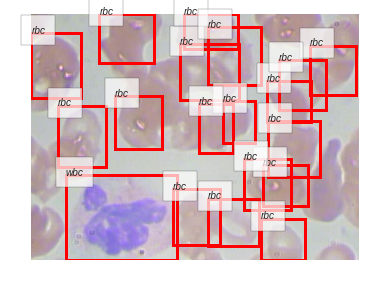

In [0]:
%matplotlib inline
from chainercv.visualizations import vis_bbox

img, bbox, label = train_dataset[0]
ax = vis_bbox(img, bbox, label, label_names=bccd_labels)
ax.set_axis_off()
ax.figure.tight_layout()

## Single Shot Multibox Detector (SSD)

データの準備が完了しました。

次に今回訓練するモデルについて簡単に説明します．今回は、[Single Shot MultiBox Detector (SSD)](https://arxiv.org/abs/1512.02325)という手法を使います．

SSDは前述のようにsingle stageタイプと呼ばれる物体検出手法の一種で，まずVGGやResNetのような画像分類で大きな成果をあげたネットワーク構造を用いて画像から**特徴マップ**を抽出します．そして特徴マップの各位置毎に候補を用意します（SSD論文ではdefault boxと呼ばれていますが，anchorという呼び方がより一般的に用いられています）．各候補領域は異なる形（正方形、縦長、横長、それらの違うサイズなど）．例えば特徴マップの(x=0, y=0)の位置に16x16の候補、16x12の候補、12x16の候補を用意します．
そして正解と最もあっている候補を求め、その**正解のbounding boxから候補がどの程度ずれているか**を計算し、このずれを最小化するように学習します。これと同時にそれぞれその領域内部に写っているものが**どのクラスに属しているか**も予測させ，この間違いも少なくするよう学習を行います．。どの正解と一致しなかった候補は何もその位置にはなかったということを予測できるようにします．

一方，two stageタイプの手法，例えばFaster R-CNNでは，抽出された特徴マップに対してさらに別のネットワークが物体の候補領域（region proposal）を予測し，その結果を使って候補領域ごとの特徴ベクトルを作成し（RoI poolingと呼ばれる計算が用いられます），それらを**クラス分類問題と候補領域の位置・大きさに対する修正量を求める回帰問題を解くための2つの異なる小さなネットワークにさらに渡す**，という構造をとります．

このため，一般にsingle stageタイプのネットワークの方が高速であると言われます．一方，two stageタイプのものの方が精度は高い，と言われます．このようなトレードオフについては、様々な物体検出手法を比較調査した論文（[Speed/accuracy trade-offs for modern convolutional object detectors](https://arxiv.org/abs/1611.10012)）より、以下の図がしばしば参照されます．
![speed-accuracy-tradeoffs.png](https://github.com/mitmul/medical-ai-course-materials/raw/master/notebooks/images/speed-accuracy-tradeoffs.png)

さて，今回用いるSSDという手法のネットワークアーキテクチャは，以下のような形をしています（SSD論文のFig. 2より引用）．

![ssd-architecture.png](https://github.com/mitmul/medical-ai-course-materials/raw/master/notebooks/images/ssd-architecture.png)

特徴抽出を行うVGG-16ネットワークは，多くの畳み込み層を積み重ねて構成されており，いくつかの畳込み層をまとめたブロックごとにプーリング処理が適用されることで特徴マップの解像度を下げ，層が積み重なるにつれてより抽象的な表現が獲得されるように設計されています．そこで，データがそれぞれのブロックを通過した時点での中間出力を保持しておき，最後に複数の異なる深さから取り出された中間出力（異なる大きさの特徴マップ）を合わせて活用することで，複数スケールの考慮を可能にしている点が，SSDの特徴となっています．

## モデルの定義

SSDのネットワーク部分の実装は，ChainerCVが提供してくれています．ChainerCVの`chainercv.links.SSD300` というクラスは，縦横が300ピクセルの画像を入力にとるSSDのモデルを表していて，デフォルトで特徴抽出器には[VGG16](https://arxiv.org/abs/1409.1556)という16層のネットワーク構造が用いられます．

学習に必要なロス関数を計算するクラスを用意しましょう．

以下に定義するクラスは，まずSSDモデルのオブジェクトと，ロス計算のためのハイパーパラメータである `alpha` と `k` をコンストラクタで受け取っています．`alpha` は、位置の予測に対する誤差とクラスの予測に対する誤差それぞれの間の重み付けを行う係数です．`k` は hard negative mining のためのパラメータです．学習時，一つの正解bounding boxに対して，モデルは最低一つの近しい（positiveな）予測と，多くの間違った（negativeな）予測を出力します．この多くの間違った予測をconfidence score（モデルがどの程度確信を持ってその予測を出力しているかを表す値）によってソートした上で，上から positive : negative が 1:k になるように negative サンプルを選択し，ロスの計算に使用します．このバランスを決めているのが `k` というパラメータで、上記論文中では $k = 3$ とされているため、ここでもデフォルトで3を使っています．

`forward` メソッドでは，入力画像と正解の位置・ラベルのリストを受け取って，実際にロスの計算を行っています．物体検出は，物体のlocalization（位置の予測）とclassification（種類（＝クラス）の予測）の二つの問題を同時に解きますが，SSDでは，localization lossとclassification lossを別々に計算します．

In [0]:
import chainer
from chainercv.links import SSD300
from chainercv.links.model.ssd import multibox_loss


class MultiboxTrainChain(chainer.Chain):

    def __init__(self, model, alpha=1, k=3):
        super(MultiboxTrainChain, self).__init__()
        with self.init_scope():
            self.model = model
        self.alpha = alpha
        self.k = k

    def forward(self, imgs, gt_mb_locs, gt_mb_labels):
        mb_locs, mb_confs = self.model(imgs)
        loc_loss, conf_loss = multibox_loss(
            mb_locs, mb_confs, gt_mb_locs, gt_mb_labels, self.k)
        loss = loc_loss * self.alpha + conf_loss

        chainer.reporter.report(
            {'loss': loss, 'loss/loc': loc_loss, 'loss/conf': conf_loss},
            self)

        return loss

    
model = SSD300(n_fg_class=len(bccd_labels), pretrained_model='imagenet')
train_chain = MultiboxTrainChain(model)

From: https://chainercv-models.preferred.jp/ssd_vgg16_imagenet_converted_2017_06_09.npz
To: /root/.chainer/dataset/_dl_cache/b4130ae0aa259c095b50ff95d81c32ee
  %   Total    Recv       Speed  Time left
100   76MiB   76MiB   4201KiB/s    0:00:00

上のセルを実行すると，自動的にImageNet-1Kデータセット（画像分類の大規模データセット）でVGG16というネットワークを訓練した際の重み（pre-trained model）がダウンロードされると思います．大規模な画像分類データセットでモデルを訓練すると，よい特徴抽出機を得ることができ，これは思いの外多くのドメインのデータに対して有効に利用できるため，このような方法は様々な場面で用いられています．特に，用意できる学習データが少ない際に，似たタスクもしくは似たデータを大量に用いて学習させておいたモデル（pre-trained model）を出発点として，少ない学習データでパラメータをさらに更新し，解きたい問題を適応させるもしくは精度を向上させるといったことをfine-tuningと呼ぶこともあります．

ChainerCVではいくつかのpre-trained modelを非常に簡単に使い始めることができるような形で提供しています．こちらに色々なpre-trained modelが一覧されています：[Pretrained Models](https://chainercv.readthedocs.io/en/latest/license.html#pretrained-models)

## Data augmentationの実装

深層学習においては大量のデータを用意できるかどうかがモデルの汎化性能に大きな影響を与えます．**データを擬似的に増やすようにデータの意味を変えずに様々な変換を画像とそれに付随するラベルに適用するテクニック（data augmentation）**は，学習用データを水増しできる手法です。

以下に，学習データセット内のデータ点のそれぞれに適用したい変換処理を記述したクラスを定義しておきます．行われる変換は`__call__`メソッド内に記述されている5つとなります．例えば画像の意味を大きくかえない範囲で色を変えたり、水平方向に反転させたり、拡大、縮小したりします。それらの際には正解ラベルも適切に変換する必要があることに注意してください。以下のセルを実行しましょう．

In [0]:
import copy

import numpy as np

from chainercv import transforms
from chainercv.links.model.ssd import random_crop_with_bbox_constraints
from chainercv.links.model.ssd import random_distort
from chainercv.links.model.ssd import resize_with_random_interpolation


class Transform(object):

    def __init__(self, coder, size, mean):
        # to send cpu, make a copy
        self.coder = copy.copy(coder)
        self.coder.to_cpu()

        self.size = size
        self.mean = mean

    def __call__(self, in_data):
        # There are five data augmentation steps
        # 1. Color augmentation
        # 2. Random expansion
        # 3. Random cropping
        # 4. Resizing with random interpolation
        # 5. Random horizontal flipping

        img, bbox, label = in_data

        # 1. Color augmentation
        img = random_distort(img)

        # 2. Random expansion
        if np.random.randint(2):
            img, param = transforms.random_expand(
                img, fill=self.mean, return_param=True)
            bbox = transforms.translate_bbox(
                bbox, y_offset=param['y_offset'], x_offset=param['x_offset'])

        # 3. Random cropping
        img, param = random_crop_with_bbox_constraints(
            img, bbox, return_param=True)
        bbox, param = transforms.crop_bbox(
            bbox, y_slice=param['y_slice'], x_slice=param['x_slice'],
            allow_outside_center=False, return_param=True)
        label = label[param['index']]

        # 4. Resizing with random interpolatation
        _, H, W = img.shape
        img = resize_with_random_interpolation(img, (self.size, self.size))
        bbox = transforms.resize_bbox(bbox, (H, W), (self.size, self.size))

        # 5. Random horizontal flipping
        img, params = transforms.random_flip(
            img, x_random=True, return_param=True)
        bbox = transforms.flip_bbox(
            bbox, (self.size, self.size), x_flip=params['x_flip'])

        # Preparation for SSD network
        img -= self.mean
        mb_loc, mb_label = self.coder.encode(bbox, label)

        return img, mb_loc, mb_label

## 学習の開始

以下では，Chainerが用意するデータセットクラスの一つ，`TransformDataset`を使って，直前に定義した変換`Transform`をデータ毎に適用するようにします．

基本的な流れはすでに学んだ画像分類やセグメンテーションなどを行うネットワークの訓練の仕方と多くが共通しているため，詳しい説明はここでは割愛します．

まずは必要なモジュール類をインポートしておきます．ここではChainerCVが提供しているSSD300を学習するニューラルネットワークに採用し，その実装を利用することにします．

In [0]:
from chainer.datasets import TransformDataset
from chainer.optimizer_hooks import WeightDecay
from chainer import serializers
from chainer import training
from chainer.training import extensions
from chainer.training import triggers
from chainercv.extensions import DetectionVOCEvaluator
from chainercv.links.model.ssd import GradientScaling

chainer.cuda.set_max_workspace_size(1024 * 1024 * 1024)
chainer.config.autotune = True

次に，以下の設定項目をあとから変更が容易なように，ここで変数に代入しておきます．

- バッチサイズ
- 使用するGPUのID
- 結果の出力ディレクトリ名
- 学習率の初期値
- 学習を行うエポック数

In [0]:
batchsize = 32
gpu_id = 0
out = 'results'
initial_lr = 0.001
training_epoch = 300
log_interval = 10, 'epoch'
lr_decay_rate = 0.1
lr_decay_timing = [200, 250]

次に，データセットクラスやイテレータを作成します．こちらはすでに学んだ画像分類の場合などと同様です．データセットから取り出されるデータ点は，それぞれ事前に定義しておいた`Transform`クラスで定義した変換処理にて変換されます．

In [0]:
transformed_train_dataset = TransformDataset(train_dataset, Transform(model.coder, model.insize, model.mean))

train_iter = chainer.iterators.MultiprocessIterator(transformed_train_dataset, batchsize)
valid_iter = chainer.iterators.SerialIterator(valid_dataset, batchsize, repeat=False, shuffle=False)

次にOptimizerを作成します．今回はMomentum SGDという手法を用いてモデルのパラメータの最適化を行います．その際に，モデルの中にある線形変換が持つバイアスのパラメータに対しては勾配が2倍の大きさになるように`update_rule`に対してフックを設定します．また，バイアスパラメータの場合にはweight decayは行わず，バイアスパラメータ以外のパラメータに対してはweight decayを行うように設定しています．これらは学習の安定化などのためにしばしば用いられるテクニックです．

In [0]:
optimizer = chainer.optimizers.MomentumSGD()
optimizer.setup(train_chain)
for param in train_chain.params():
    if param.name == 'b':
        param.update_rule.add_hook(GradientScaling(2))
    else:
        param.update_rule.add_hook(WeightDecay(0.0005))

次にUpdaterのオブジェクトを作成します．今回はUpdaterに最もシンプルな`StandardUpdater`を用いました．CPUもしくはシングルGPUを用いて学習を行う際には，このUpdaterを使います．

In [0]:
updater = training.updaters.StandardUpdater(
    train_iter, optimizer, device=gpu_id)

最後に，Trainerオブジェクトを作成します．

In [0]:
trainer = training.Trainer(
    updater,
    (training_epoch, 'epoch'), out)

Trainer Extensionの追加などは以前の章で説明したものから目新しいものはありませんが，以下のExponentialShiftを使った学習率の減衰については，`ManualScheduleTrigger`という新しい減衰のタイミングの指定方法が使われています．これはシンプルに，`[200, 250]`などのようにそのExtentionを起動したいタイミングを表す数字が並んだリストと，その単位（ここでは`epoch`）を渡すと，指定されたタイミングのみでそのExtensionが発動するというものです．以下のコードでは，`lr_decay_timing`に上で`[200, 250]`を代入していますので，200エポックと250エポックの時点でExponentialShiftが発動し，学習率を`lr_decay_rate`倍，つまり上で設定したように，$0.1$倍するというものになっています．

In [0]:
trainer.extend(
    extensions.ExponentialShift('lr', lr_decay_rate, init=initial_lr),
    trigger=triggers.ManualScheduleTrigger(lr_decay_timing, 'epoch'))

### 評価指標

物体検出では，**モデルが「検出」と判断したbbox（一定以上のconfidenceが与えられたbbox）が，実際に正解のbboxとIoU > 0.5以上になっている場合をTrue Positive**として，**平均適合率（Average precision; AP）**を用いて評価を行うのが一般的です．また，これをクラスごとに算出していき全体で平均をとったMean average precision（mAP）も用いられます．IoUについては，前章のSemantic Segmentationについての解説の中で説明していますが，物体検出におけるIoUも同様で，予測した矩形と正解の矩形のいずれかまたは両方が囲っている領域の大きさで共通して囲っている領域の大きさを割ったものを指します．

ChainerCVが提供する`DetectionVOCEvaluator`というExtensionは，渡されたイテレータ（ここではvalidation datasetに対して作成したval_iterというイテレータ）を使って，各クラスごとのAPや全体のmAPを学習中に計算してくれます．ここでもこのExtensionを利用します．

In [0]:
trainer.extend(
    DetectionVOCEvaluator(
        valid_iter, model, use_07_metric=False,
        label_names=bccd_labels),
    trigger=(1, 'epoch'))

では，その他のよく用いるExtensionを一通り追加しておきましょう．今回，学習の途中結果は10エポックごとに保存することにします．

In [0]:
trainer.extend(extensions.LogReport(trigger=log_interval))
trainer.extend(extensions.observe_lr(), trigger=log_interval)
trainer.extend(extensions.PrintReport(
    ['epoch', 'iteration', 'lr',
     'main/loss', 'main/loss/loc', 'main/loss/conf',
     'validation/main/map', 'elapsed_time']),
    trigger=log_interval)
if extensions.PlotReport.available():
    trainer.extend(
        extensions.PlotReport(
            ['main/loss', 'main/loss/loc', 'main/loss/conf'],
            'epoch', file_name='loss.png'))
    trainer.extend(
        extensions.PlotReport(
            ['validation/main/map'],
            'epoch', file_name='accuracy.png'))
trainer.extend(extensions.snapshot(
    filename='snapshot_epoch_{.updater.epoch}.npz'), trigger=(10, 'epoch'))

さて，本来，ここで

```python
trainer.run()
```

と実行すれば，早速学習が始まるのですが，100分ほどの時間がかかってしまいます．そこで，まさにこのスクリプトを事前に実行し，290エポックまで学習した結果を保存しておきましたので，これを読みこんで，最後の10エポックだけ学習してみましょう．まず，290エポック時点までの学習途中のsnapshotをダウンロードします．

In [0]:
!wget https://github.com/japan-medical-ai/medical-ai-course-materials/releases/download/v0.1/detection_snapshot_epoch_290.npz

次に，このダウンロードした`detection_snapshot_epoch_250.npz`というファイルを先程作成したTrainerオブジェクトに読み込んでみましょう．

In [0]:
chainer.serializers.load_npz('detection_snapshot_epoch_290.npz', trainer)

では，最後の10エポックだけ学習を行いましょう．以下のセルを実行して，少しだけ待ってください．

In [0]:
trainer.run()

epoch       iteration   lr          main/loss   main/loss/loc  main/loss/conf  validation/main/map  elapsed_time
10          65          0.001       6.75134     2.08291        4.66843         0.118168             230.543       
20          129         0.001       4.12112     1.58375        2.53737         0.181493             435.038       
30          193         0.001       3.59885     1.31919        2.27966         0.279919             635.634       
40          257         0.001       3.1998      1.07375        2.12605         0.573733             835.256       
50          321         0.001       2.94131     0.926096       2.01522         0.657611             1034.6        
60          385         0.001       2.86323     0.887698       1.97553         0.670849             1233.12       
70          449         0.001       2.73648     0.819021       1.91746         0.696257             1428.25       
80          513         0.001       2.63796     0.765831       1.87212         0.6

学習が完了しました。次の節からはこの学習の結果得られた新しいスナップショットを使って，**未知のデータに対する推論**を行ってみます．

## 学習結果を用いた推論

学習を行った結果得られるモデルのパラメータは，`extensions.snapshot()`というTrainer extensionによってファイルに保存されています．保存先は，デフォルトではTrainerオブジェクト初期化時に渡した`out`という引数によって指定されたディレクトリ以下となります．今回は，`results`以下にあるはずです．

In [0]:
!ls -la results/

total 175520
drwxr-xr-x 2 root root      4096 Nov 15 10:21 .
drwxr-xr-x 1 root root      4096 Nov 15 10:16 ..
-rw-r--r-- 1 root root     16467 Nov 15 10:20 accuracy.png
-rw-r--r-- 1 root root     14212 Nov 15 10:20 log
-rw-r--r-- 1 root root     19244 Nov 15 10:20 loss.png
-rw-r--r-- 1 root root 179665484 Nov 15 10:21 snapshot_epoch_300.npz


以上のようなシェルコマンドを実行した結果，`snapshot_epoch_300.npz`というファイルが見つかったはずです．これは学習中にTrainerの中にあった学習を再開するために必要なパラメータをまとまて保存したものです．そのため，Optimizerが内部にもつパラメータなど，モデルそのものが内部に持っていたパラメータ以外のものも一緒に保存されています．そこで，今回は推論に必要なモデルのパラメータだけをこのファイルから取り出して用いてみます．

モデルのパラメータを取り出す方法としては，`chainer.serializers.load_npz`を用いて`.npz`ファイルをモデルオブジェクトにロードする際に，`.npz`ファイルのキーに対して**ある階層以下のものだけ見るように指定する**方法があります．Trainerオブジェクト全体のスナップショットをとった場合には，Optimizerが持つiteration回数の情報など，モデル内部のパラメータ以外のものも格納されていますが，`updater/model:main/model`というprefixを渡せば，モデルのパラメータ部分のみを取り出すことができます．

では，学習に用いたのとは別の場所で，このスナップショットとモデルの定義のコードだけが渡された状況を想定して，新しいモデルオブジェクトを作成し，そこに学習済みパラメータをロードしてみましょう．


In [0]:
# Create a model object
model = SSD300(n_fg_class=len(bccd_labels), pretrained_model='imagenet')

# Load parameters to the model
chainer.serializers.load_npz(
    'results/snapshot_epoch_300.npz', model, path='updater/model:main/model/')

では，学習済みの重みをロードしたモデルを使って，テスト画像の一つに対して細胞の検出処理を行ってみます．以下のコードでは，画像の読み込み，推論の実行，そして結果の可視化までをChainerCVを用いて順に行っています．

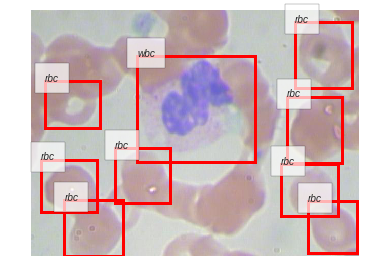

In [0]:
from chainercv import utils

def inference(image_filename):
    # Load a test image
    img = utils.read_image(image_filename, color=True)

    # Perform inference
    bboxes, labels, scores = model.predict([img])

    # Extract the results
    bbox, label, score = bboxes[0], labels[0], scores[0]

    # Visualize the detection results
    ax = vis_bbox(img, bbox, label, label_names=bccd_labels)
    ax.set_axis_off()
    ax.figure.tight_layout()
    
inference('BCCD_Dataset/BCCD/JPEGImages/BloodImage_00007.jpg')

さらにいくつかの画像に対して推論を行って，結果を見てみましょう．

BloodImage_00007



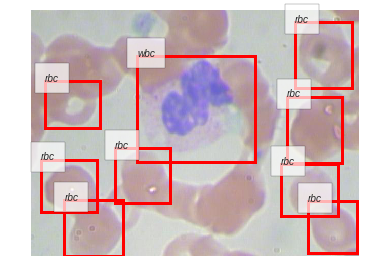

BloodImage_00011



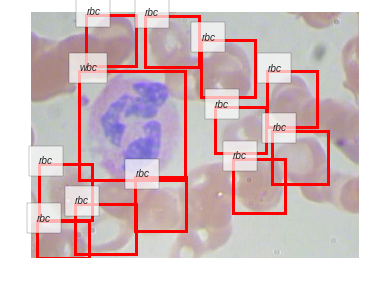

BloodImage_00015



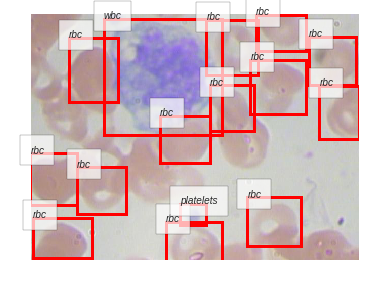

BloodImage_00016



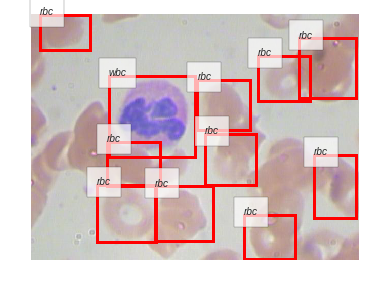

BloodImage_00018



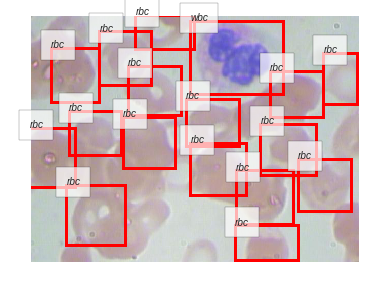

BloodImage_00019



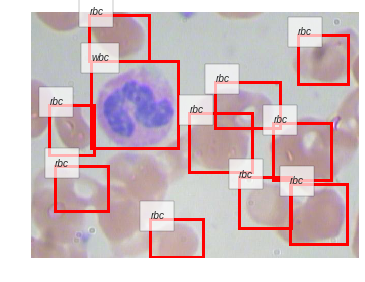

BloodImage_00021



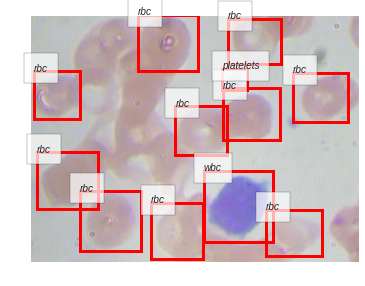

In [0]:
import matplotlib.pyplot as plt

for i, image_filename in enumerate(open('BCCD_Dataset/BCCD/ImageSets/Main/test.txt')):
    print(image_filename)
    plt.clf()
    inference('BCCD_Dataset/BCCD/JPEGImages/' + image_filename.strip() + '.jpg')
    plt.show()

    if i > 5:  # 5+1個表示したら終わる
        break

## 学習したモデルの評価

学習が終わったら，得られたモデルをテストデータセットで評価します．検証用データセット（validation dataset）は，学習中にパラメータの更新量を計算するためには直接用いていませんが，学習率や学習率減衰の比率・タイミングなどの**ハイパーパラメータの調整を行うために用いている**ため，**厳密に言えば学習時に使っていないデータとは呼べません．**そのため，最終的に得られたモデルがどの程度の汎化性能を発揮しそうか目安を得るためには，**学習用・検証用データセットのいずれにも含まれない第三のデータセットを用いた評価を行う必要があります．**

ChainerのTrainer Extensionsの一つであるEvaluatorは，実はTrainerと一緒にでなくても，単独で使用することができます．ChainerCVが提供している`DetectionVOCEvaluator`も，ChainerのEvaluatorを継承して作られた機能拡張版Evaluatorなので，同様にTrainerとは無関係に評価のためだけに使うことができます．

それでは，初めの方に用意しておいた`test_dataset`を使ってまずはイテレータを作り，それを`DetectionVOCEvaluator`に先程も使った学習済みモデルと一緒に渡して，**テストデータセットを用いた最終的な性能評価**を行ってみましょう．

In [0]:
test_batchsize = 256

model.to_gpu()

test_iter = chainer.iterators.SerialIterator(
    test_dataset, test_batchsize, repeat=False, shuffle=False)

test_evaluator = DetectionVOCEvaluator(
    test_iter, model, use_07_metric=False,
    label_names=bccd_labels)

test_evaluator()

{'main/ap/platelets': 0.43160541189100443,
 'main/ap/rbc': 0.7560813687514889,
 'main/ap/wbc': 0.9657403882755995,
 'main/map': 0.7178090563060309}

ここに表示された結果を見ると，白血球に対する予測が最も正確で，次いで赤血球，一方血小板に対する予測は他の二つに比べるとかなり低くなっていることが分かりました．こうした場合は血小板・赤血球・白血球はそれぞれ，同程度の頻度でデータセット中に登場しているのかを確認する必要があります．頻度がクラスごとに大きくことなるとしたら，モデルは頻度の低いクラスを頻度の高いクラスよりも少ない回数しか観測できていないと思われます．それらを完全に同列に扱って（区別せず）学習を行うのは最適なやり方ではありません．

実際の応用で物体検出器を訓練する場合にも，まず有名なモデルを使って学習を行ってみて結果を作ったあと，その結果とデータを突き合わせて，モデルの予測の傾向やデータセット自体の特徴などを吟味する段階が重要になります．

Class imbalanceの問題については，[Focal loss](https://arxiv.org/abs/1708.02002)という手法がシンプルかつ強力な提案を行っています．参考になるかもしれません．